In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import json
from PIL import Image
import cv2
import albumentations as A

import time

from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# drive mount


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pwd
%cd /content/drive/MyDrive/OCT_layer_segmentation-U_Net-Resnet
#from data.seg_dataset import segList
#import data.seg_transforms as dt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content/drive/MyDrive/OCT/MGU-Net-main


Image Size (992, 1024, 3)
Mask Size (992, 1024)


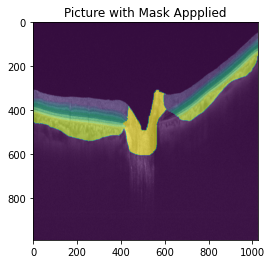

In [ ]:
#img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
img = cv2.imread('/content/drive/MyDrive/OCT_layer_segmentation-U_Net-Resnet/data/dataset/train/img/10_R_09.bmp')
mask = Image.open('/content/drive/MyDrive/OCT_layer_segmentation-U_Net-Resnet/data/dataset/train/mask/10_R_09.bmp')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()



In [ ]:
img1 = cv2.imread('/content/drive/MyDrive/OCT_layer_segmentation-U_Net-Resnet/data/dataset/train/mask/10_R_09.bmp')

img1 = np.array(img1, dtype='int32')
len(np.unique(img1))

11

# Dataset

In [ ]:
import data.seg_transforms as dt
from data.seg_dataset import segList
import os.path as osp
data_dir= '/content/drive/MyDrive/OCT_layer_segmentation-U_Net-Resnet/data/dataset'
workers =2
info = json.load(open(osp.join(data_dir, 'info.json'), 'r'))
normalize = dt.Normalize(mean=info['mean'], std=info['std'])
t = []
t.extend([dt.Label_Transform(),dt.ToTensor(),normalize])
train_dataset = segList(data_dir, 'train', dt.Compose(t))
val_dataset = segList(data_dir, 'eval', dt.Compose(t))
test_dataset = segList(data_dir, 'test', dt.Compose(t))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=3, shuffle=True, num_workers=workers, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=3, shuffle=False, num_workers=workers, pin_memory=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=workers, pin_memory=False)

Total amount of train images is : 148
Total amount of eval images is : 48
Total amount of test images is : 48


# Model

To use different model change the name of the model to the anyone of the following: Unet, UnetPlusPlus, MAnet, Linknet, FPN, PSPNet, PAN, DeepLabV3, DeepLabV3Plus
https://smp.readthedocs.io/en/latest/index.html

In [ ]:
model = smp.Unet(encoder_name='efficientnet-b7', encoder_depth=5, encoder_weights='imagenet', decoder_channels=(256, 128, 64, 32, 16), in_channels=1, classes=11, activation=None, aux_params=None)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

# Training

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=11):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data

            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            #print(output)
            #print(mask)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet_resnet_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
torch.cuda.empty_cache()

max_lr = 1e-3
epoch = 5
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

In [ ]:
torch.save(model, 'Unet_resnet.pt')

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Evaluation

In [ ]:
image, mask, [original_image, original_mask] = test_dataset[0]
mean=info['mean']
std=info['std']
model= torch.load('Unet_resnet.pt')

## Result

In [ ]:
def predict_image_mask_miou(model, image, mask, mean, std):
    model.eval()
    #t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    #image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean, std):
    model.eval()
    #t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    #image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:

pred_mask, score = predict_image_mask_miou(model, image, mask, mean, std)

In [ ]:
def miou_score(model, test_set, mean, std):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask,[_,_] = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask , mean, std)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, test_dataset, mean, std)

In [ ]:
def pixel_acc(model, test_set, mean, std):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask,[_,_] = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask, mean, std)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_dataset, mean, std)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(original_image)
ax1.set_title('Picture');

ax2.imshow(original_mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('Unet_resnet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [ ]:
image2, mask2,[a,b] = test_dataset[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2, mean, std)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(a)
ax1.set_title('Picture');

ax2.imshow(b)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('Unet_resnet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

In [ ]:
image3, mask3,[i,j] = test_dataset[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3, mean, std)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(i)
ax1.set_title('Picture');

ax2.imshow(j)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('Unet_resnet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

In [ ]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))